# Phân loại Malware Dựa trên Phân tích Lưu lượng Mạng
---

## Bước 1: Khám phá và Chuẩn bị Dữ liệu (EDA & Setup)

### 1.1 - Đọc và kiểm tra dữ liệu tổng quan

In [1]:
import pandas as pd
from collections import Counter

# Đọc dữ liệu và chuẩn hóa tên cột
df = pd.read_csv("../data/Malware_subset.csv")
df.columns = df.columns.str.lower()  

df.head()

,source port,destination port,protocol,flow duration,total fwd packets,total backward packets,total length of fwd packets,total length of bwd packets,fwd packet length max,fwd packet length min,...,min_seg_size_forward,active mean,active std,active max,active min,idle mean,idle std,idle max,idle min,label
0,43399,443,6,36586,1,1,0.0,0.0,0.0,0.0,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ADWARE_FEIWO
1,40422,443,6,36984,1,1,0.0,0.0,0.0,0.0,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ADWARE_FEIWO
2,56977,80,6,15638963,5,5,405.0,448.0,405.0,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ADWARE_FEIWO
3,60652,80,6,15660249,5,5,405.0,448.0,405.0,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ADWARE_FEIWO
4,44512,80,6,14456391,5,3,268.0,519.0,268.0,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ADWARE_FEIWO


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834695 entries, 0 to 834694
Data columns (total 81 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    source port                  834695 non-null  int64  
 1    destination port             834695 non-null  int64  
 2    protocol                     834695 non-null  int64  
 3    flow duration                834695 non-null  int64  
 4    total fwd packets            834695 non-null  int64  
 5    total backward packets       834695 non-null  int64  
 6   total length of fwd packets   834695 non-null  float64
 7    total length of bwd packets  834695 non-null  float64
 8    fwd packet length max        834695 non-null  float64
 9    fwd packet length min        834695 non-null  float64
 10   fwd packet length mean       834695 non-null  float64
 11   fwd packet length std        834695 non-null  float64
 12  bwd packet length max         834695 non-nul

In [3]:
# Kiểm tra sự phân bố của các lớp nhãn --> Dữ liệu mất cân bằng (imbalanced)
df['label'].value_counts()

BENIGN             410548
ADWARE_GOOLIGAN     93772
ADWARE_FEIWO        56632
ADWARE_EWIND        43374
ADWARE_DOWGIN       39682
ADWARE_SHUANET      39271
ADWARE_KEMOGE       38771
ADWARE_YOUMI        36035
ADWARE_KOODOUS      32547
ADWARE_MOBIDASH     31034
ADWARE_SELFMITE     13029
Name: label, dtype: int64

### 1.2 - Phân tích phân phối dữ liệu số
*Nhận xét: Nhiều cột có giá trị ngoại lai (outliers) rất lớn, cho thấy việc chuẩn hóa (scaling) là cần thiết.*

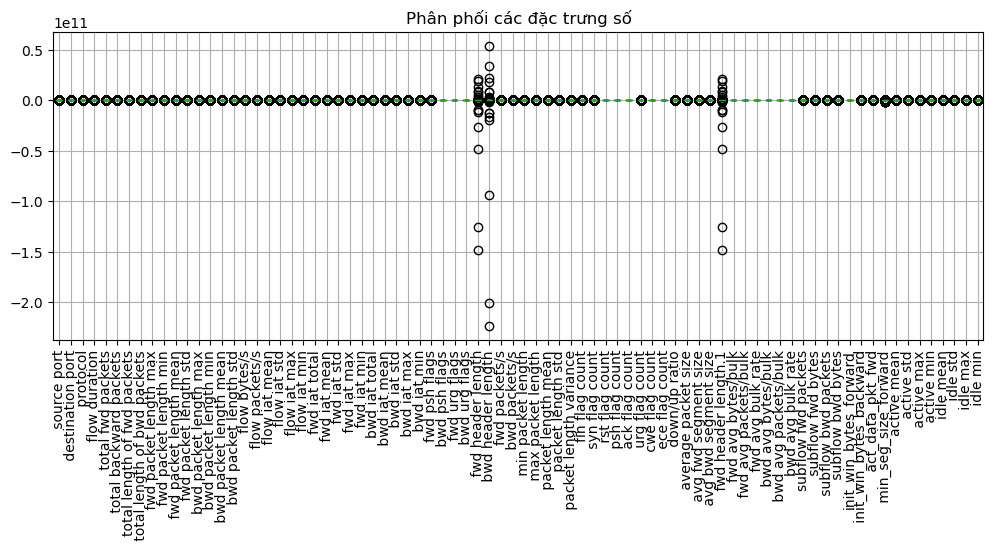

In [4]:
import matplotlib.pyplot as plt

df.boxplot(column=list(df.select_dtypes('number').columns), rot=90, figsize=(12,4))
plt.title("Phân phối các đặc trưng số")
plt.show()

## Bước 2: Tiền xử lý Dữ liệu

### 2.1 - Chia tập Huấn luyện (Train) và Kiểm tra (Test)
- **Tỷ lệ:** 80% cho train, 20% cho test.
- **`stratify=y`:** Đảm bảo tỷ lệ phân bố các lớp nhãn trong tập train và test là như nhau, rất quan trọng với dữ liệu mất cân bằng.

In [5]:
from sklearn.model_selection import train_test_split

X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Kích thước tập Train: {X_train.shape}")
print(f"Kích thước tập Test:  {X_test.shape}")

Kích thước tập Train: (667756, 80)
Kích thước tập Test:  (166939, 80)


- Phân bố các lớp trên tập kiểm thử

In [6]:
y_test.value_counts()

BENIGN             82110
ADWARE_GOOLIGAN    18754
ADWARE_FEIWO       11327
ADWARE_EWIND        8675
ADWARE_DOWGIN       7936
ADWARE_SHUANET      7854
ADWARE_KEMOGE       7754
ADWARE_YOUMI        7207
ADWARE_KOODOUS      6509
ADWARE_MOBIDASH     6207
ADWARE_SELFMITE     2606
Name: label, dtype: int64

### 2.2 - Mã hóa Nhãn (Label Encoding)
- Chuyển các nhãn dạng chữ (e.g., 'BENIGN') thành số (e.g., 10) để mô hình có thể xử lý.
- Lưu lại bộ mã hóa (`LabelEncoder`) và bản đồ ánh xạ (`label_mapping`) để tái sử dụng sau này.

In [7]:
from sklearn.preprocessing import LabelEncoder
import os, json, joblib

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

label_map = {label: int(idx) for idx, label in enumerate(le.classes_)}
print("Bản đồ ánh xạ Nhãn -> Số:", label_map)

os.makedirs("../outputs", exist_ok=True)
joblib.dump(le, "../outputs/label_encoder.pkl")
with open("../outputs/label_mapping.json", "w", encoding="utf-8") as f:
    json.dump(label_map, f, ensure_ascii=False, indent=2)

Bản đồ ánh xạ Nhãn -> Số: {'ADWARE_DOWGIN': 0, 'ADWARE_EWIND': 1, 'ADWARE_FEIWO': 2, 'ADWARE_GOOLIGAN': 3, 'ADWARE_KEMOGE': 4, 'ADWARE_KOODOUS': 5, 'ADWARE_MOBIDASH': 6, 'ADWARE_SELFMITE': 7, 'ADWARE_SHUANET': 8, 'ADWARE_YOUMI': 9, 'BENIGN': 10}


### 2.3 - So sánh các scaler (bonus)
*Lưu ý: chạy bước 3.1 để tạo tập con trước*

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

num_cols = X_train.select_dtypes(include='number').columns

def make_preprocessor(scaler):
    numeric_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', scaler)
    ])
    return ColumnTransformer([('num', numeric_pipeline, num_cols)], remainder='drop')

scalers = {
    'standard': StandardScaler(),
    'minmax': MinMaxScaler(),
    'quantile-normal': QuantileTransformer(output_distribution='normal',
                                           n_quantiles=1000,
                                           subsample=50_000,
                                           random_state=42)
}

results = []
print("Bắt đầu so sánh các scaler trên tập con (subset)...")

for name, scaler_instance in scalers.items():
    full_pipe = Pipeline([
        ('prep', make_preprocessor(scaler_instance)),
        ('model', RandomForestClassifier(
            n_estimators=150,
            class_weight='balanced_subsample',
            n_jobs=-1,
            random_state=42))
    ])

    full_pipe.fit(X_sub, y_sub)

    y_pred_test = full_pipe.predict(X_test)

    results.append({
        'scaler': name,
        'accuracy': accuracy_score(y_test_enc, y_pred_test),
        'macro_precision': precision_score(y_test_enc, y_pred_test, average='macro', zero_division=0),
        'macro_recall': recall_score(y_test_enc, y_pred_test, average='macro', zero_division=0),
        'macro_f1': f1_score(y_test_enc, y_pred_test, average='macro', zero_division=0),
    })
    print(f"Hoàn thành scaler {name}")

df_scalers_results = pd.DataFrame(results).sort_values('macro_f1', ascending=False)

print("\n--- Kết quả so sánh các scaler ---")
display(df_scalers_results)

Bắt đầu so sánh các scaler trên tập con (subset)...
Hoàn thành scaler standard
Hoàn thành scaler minmax
Hoàn thành scaler quantile-normal

--- Kết quả so sánh các scaler ---


,scaler,accuracy,macro_precision,macro_recall,macro_f1
0,standard,0.532680,0.340011,0.228377,0.258236
2,quantile-normal,0.534195,0.344135,0.226220,0.256453
1,minmax,0.518141,0.314388,0.228922,0.254235


### 2.3 - Xây dựng Pipeline Tiền xử lý
- Sử dụng `ColumnTransformer` để áp dụng các bước xử lý riêng cho từng loại dữ liệu:
  - **Cột số:** Điền giá trị thiếu (impute) bằng `median`, sau đó chuẩn hóa (scale) bằng `StandardScaler`.
  - **Cột chữ/hạng mục:** Điền giá trị thiếu bằng `most_frequent`.
- Đóng gói thành một `preprocessor` giúp quy trình gọn gàng, tránh rò rỉ dữ liệu.

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_cols = X_train.select_dtypes(include='number').columns
cat_cols = X_train.select_dtypes(exclude='number').columns

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_cols),
    ('cat', categorical_pipeline, cat_cols)
])

## Bước 3: Thử nghiệm nhanh & Lựa chọn Mô hình

### 3.1 - Tạo Tập con (Subset) để Thử nghiệm nhanh
- Lấy một mẫu **100,000 dòng** có phân tầng từ tập train.
- Tất cả các bước so sánh, đánh giá ban đầu sẽ được thực hiện trên tập con này để **tiết kiệm thời gian**.

In [9]:
import numpy as np

X_sub, _, y_sub, _ = train_test_split(
    X_train, y_train_enc,
    train_size=100_000, 
    stratify=y_train_enc,
    random_state=42
)

# (Tùy chọn) Giảm kiểu dữ liệu để tiết kiệm RAM
X_sub = X_sub.astype(np.float32)
print("Kích thước tập con để thử nghiệm:", X_sub.shape)

Kích thước tập con để thử nghiệm: (100000, 80)


### 3.2 - Đánh giá nhanh các mô hình cơ bản (trên tập con)
- So sánh 3 mô hình phổ biến trên tập con để xem kiến trúc nào có tiềm năng nhất.
- **Lưu ý:** `pipe.fit(X_sub, y_sub)` được huấn luyện trên tập con nên sẽ chạy rất nhanh.

*Kết quả: RandomForest và XGBoost cho kết quả vượt trội, sẽ được chọn để tối ưu hóa ở bước sau.*

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

models = {
    "LogReg": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(
        n_estimators=150, class_weight="balanced_subsample", n_jobs=-1, random_state=42
    ),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=100, random_state=42)
}

for name, clf in models.items():
    pipe = Pipeline([('prep', preprocessor), ('model', clf)])
    
    # Huấn luyện trên TẬP CON để có kết quả nhanh
    pipe.fit(X_sub, y_sub)
    
    # Đánh giá vẫn thực hiện trên tập test đầy đủ
    y_pred = pipe.predict(X_test)
    print(f"--- Đánh giá mô hình: {name} ---")
    print(classification_report(
        y_test_enc, y_pred,
        target_names=le.classes_, digits=4
    ))
    print("="*50 + "\n")

--- Đánh giá mô hình: LogReg ---
                 precision    recall  f1-score   support

  ADWARE_DOWGIN     0.0633    0.2799    0.1032      7936
   ADWARE_EWIND     0.0875    0.0584    0.0701      8675
   ADWARE_FEIWO     0.0820    0.0574    0.0675     11327
ADWARE_GOOLIGAN     0.2692    0.2340    0.2504     18754
  ADWARE_KEMOGE     0.0798    0.2364    0.1193      7754
 ADWARE_KOODOUS     0.0615    0.2403    0.0980      6509
ADWARE_MOBIDASH     0.0553    0.0963    0.0703      6207
ADWARE_SELFMITE     0.0231    0.1688    0.0407      2606
 ADWARE_SHUANET     0.0915    0.0609    0.0731      7854
   ADWARE_YOUMI     0.0715    0.0579    0.0639      7207
         BENIGN     0.6000    0.0916    0.1590     82110

       accuracy                         0.1235    166939
      macro avg     0.1350    0.1438    0.1014    166939
   weighted avg     0.3544    0.1235    0.1383    166939


--- Đánh giá mô hình: RandomForest ---
                 precision    recall  f1-score   support

  ADWARE_DO

c:\Users\ASUS\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning: [02:39:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Đánh giá mô hình: XGBoost ---
                 precision    recall  f1-score   support

  ADWARE_DOWGIN     0.6205    0.1249    0.2079      7936
   ADWARE_EWIND     0.3602    0.0330    0.0604      8675
   ADWARE_FEIWO     0.3862    0.1008    0.1599     11327
ADWARE_GOOLIGAN     0.7186    0.4158    0.5268     18754
  ADWARE_KEMOGE     0.5668    0.1286    0.2096      7754
 ADWARE_KOODOUS     0.8102    0.1312    0.2258      6509
ADWARE_MOBIDASH     0.4026    0.0150    0.0289      6207
ADWARE_SELFMITE     0.3125    0.0077    0.0150      2606
 ADWARE_SHUANET     0.2830    0.0289    0.0524      7854
   ADWARE_YOUMI     0.6323    0.0604    0.1102      7207
         BENIGN     0.5452    0.9704    0.6982     82110

       accuracy                         0.5542    166939
      macro avg     0.5126    0.1833    0.2086    166939
   weighted avg     0.5417    0.5542    0.4535    166939




## Bước 4: Tối ưu hóa Siêu tham số (Hyperparameter Tuning)
- Dùng `RandomizedSearchCV` để tự động tìm kiếm bộ tham số tốt nhất cho các mô hình tiềm năng.
- Quá trình này vẫn được chạy trên **tập con `X_sub`** để đảm bảo tốc độ.

### 4.1 - RandomizedSearchCV cho XGBoost

In [13]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Lưu ý: XGBoost thường không cần StandardScaler, nên ta có thể dùng preprocessor "light" hơn
preprocessor_light = ColumnTransformer(
    transformers=[('num', SimpleImputer(strategy='median'), num_cols)],
    remainder='drop'
)

xgb_pipe = Pipeline([
    ('prep', preprocessor_light),
    ('model', XGBClassifier(
        tree_method='hist', eval_metric='mlogloss', use_label_encoder=False,
        n_jobs=1, random_state=42
    ))
])

xgb_dist = {
    'model__n_estimators': randint(150, 400),
    'model__max_depth': [4, 6, 8, 10],
    'model__subsample': uniform(0.6, 0.4),
    'model__colsample_bytree': uniform(0.6, 0.4),
}

xgb_search = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=xgb_dist,
    n_iter=12, # Số lần thử ngẫu nhiên
    scoring='f1_macro',
    cv=3,
    n_jobs=4, # Chạy song song để tăng tốc
    random_state=42,
    verbose=1
)

xgb_search.fit(X_sub, y_sub)
xgb_best = xgb_search.best_estimator_
print("\nCác tham số XGBoost tốt nhất:", xgb_search.best_params_)
print("Điểm F1-macro CV tốt nhất (trên tập con):", xgb_search.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


c:\Users\ASUS\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning: [02:59:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Các tham số XGBoost tốt nhất: {'model__colsample_bytree': 0.8056937753654446, 'model__max_depth': 10, 'model__n_estimators': 398, 'model__subsample': 0.6185801650879991}
Điểm F1-macro CV tốt nhất (trên tập con): 0.2697960890641117


### 4.2 - RandomizedSearchCV cho RandomForest

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# 1. Tạo Pipeline cho RandomForest
# Sử dụng preprocessor đầy đủ vì RF có thể hưởng lợi từ StandardScaler
rf_pipe = Pipeline([
    ('prep', preprocessor),
    ('model', RandomForestClassifier(
        class_weight='balanced_subsample',
        n_jobs=1,  # Quan trọng: Đặt là 1 để tránh xung đột với n_jobs của RandomizedSearchCV
        random_state=42
    ))
])

# 2. Định nghĩa không gian siêu tham số để tìm kiếm
rf_dist = {
    'model__n_estimators': randint(150, 400),
    'model__max_depth': [8, 10, 12, None],
    'model__min_samples_leaf': [2, 4, 6],
    'model__max_features': ['sqrt', 'log2']
}

# 3. Cấu hình và chạy RandomizedSearchCV
rf_search = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=rf_dist,
    n_iter=12,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1,  # Sử dụng tất cả các lõi CPU để chạy song song
    random_state=42,
    verbose=2
)

rf_search.fit(X_sub, y_sub)
rf_best = rf_search.best_estimator_

# 4. Lấy ra kết quả và mô hình tốt nhất
print("\\nCác tham số RandomForest tốt nhất:", rf_search.best_params_)
print("Điểm F1-macro CV tốt nhất (trên tập con):", rf_search.best_score_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
\nCác tham số RandomForest tốt nhất: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__n_estimators': 280}
Điểm F1-macro CV tốt nhất (trên tập con): 0.25193734286935693


## Bước 5: Huấn luyện Mô hình Cuối cùng & Đánh giá

### 5.1 - Chốt mô hình và huấn luyện trên TOÀN BỘ tập train
- Sau khi đã tìm được mô hình và bộ tham số tốt nhất, ta sẽ huấn luyện nó trên **toàn bộ tập `X_train`**.
- Việc này giúp mô hình học được nhiều thông tin nhất có thể trước khi đưa ra đánh giá cuối cùng.

In [26]:
from sklearn.metrics import f1_score

final_pipe = xgb_best

print("Bắt đầu huấn luyện mô hình cuối cùng trên toàn bộ tập train...")
final_pipe.fit(X_train, y_train_enc)
print("Huấn luyện hoàn tất!")

Bắt đầu huấn luyện mô hình cuối cùng trên toàn bộ tập train...


c:\Users\ASUS\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning: [22:04:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Huấn luyện hoàn tất!


### 5.2 - Đánh giá cuối cùng trên tập Test
- Đây là bước quan trọng nhất, đánh giá hiệu năng của mô hình trên tập dữ liệu `X_test` mà nó chưa từng thấy.
- Kết quả ở đây là thước đo khách quan nhất về hiệu quả của mô hình.

In [27]:
y_pred_final  = final_pipe.predict(X_test)

# Lấy xác suất dự đoán để phân tích ngưỡng ở bước sau
if hasattr(final_pipe.named_steps['model'], "predict_proba"):
    y_proba_final = final_pipe.predict_proba(X_test)

print("--- Báo cáo Phân loại Cuối cùng (trên tập Test) ---\n")
print(classification_report(
    y_test_enc, y_pred_final,
    target_names=le.classes_, digits=4
))

--- Báo cáo Phân loại Cuối cùng (trên tập Test) ---

                 precision    recall  f1-score   support

  ADWARE_DOWGIN     0.6342    0.2899    0.3980      7936
   ADWARE_EWIND     0.5365    0.2259    0.3180      8675
   ADWARE_FEIWO     0.4918    0.2635    0.3432     11327
ADWARE_GOOLIGAN     0.8217    0.5555    0.6629     18754
  ADWARE_KEMOGE     0.6200    0.3045    0.4084      7754
 ADWARE_KOODOUS     0.6288    0.2543    0.3621      6509
ADWARE_MOBIDASH     0.4777    0.1568    0.2361      6207
ADWARE_SELFMITE     0.4766    0.1251    0.1982      2606
 ADWARE_SHUANET     0.4985    0.1928    0.2780      7854
   ADWARE_YOUMI     0.5553    0.2235    0.3188      7207
         BENIGN     0.6139    0.9406    0.7429     82110

       accuracy                         0.6190    166939
      macro avg     0.5777    0.3211    0.3879    166939
   weighted avg     0.6116    0.6190    0.5704    166939



## Bước 6: Phân tích sâu Kết quả

### 6.1 - Ma trận nhầm lẫn (Confusion Matrix)
- Trực quan hóa kết quả để xem mô hình đang dự đoán đúng/sai ở những lớp nào.
  - **Bản đồ nhiệt (counts):** Hiển thị số lượng mẫu thực tế.
  - **Bản đồ chuẩn hóa (normalized):** Hiển thị tỷ lệ recall của từng lớp trên đường chéo chính.

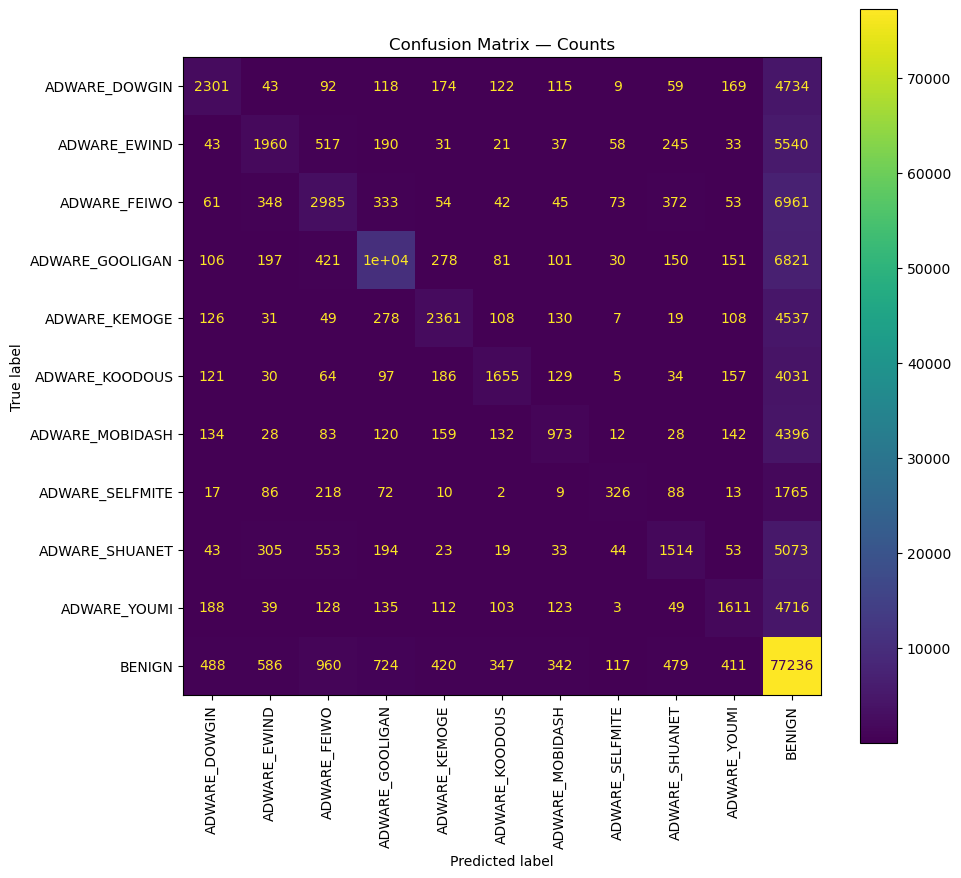

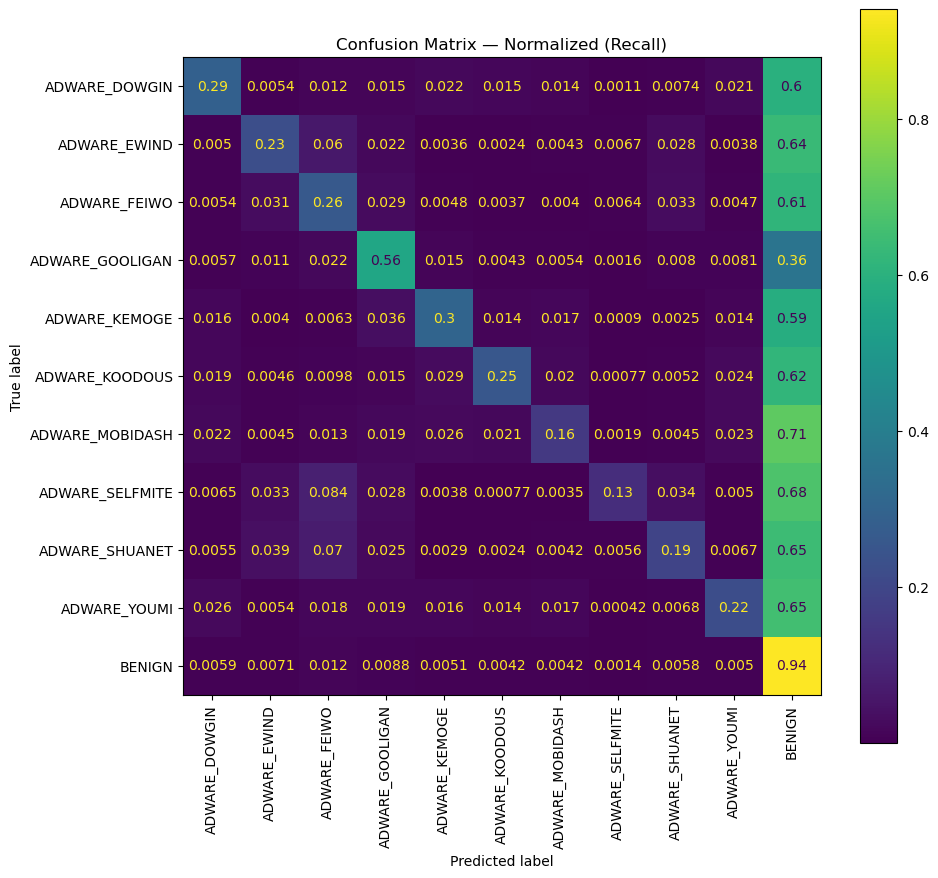

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay

# Vẽ ma trận với số đếm
fig, ax = plt.subplots(figsize=(10, 9))
ConfusionMatrixDisplay.from_predictions(
    y_test_enc, y_pred_final, display_labels=le.classes_,
    normalize=None, cmap="viridis", ax=ax
)
ax.set_title("Confusion Matrix — Counts")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("../outputs/cm_counts.png", dpi=150)
plt.show()

# Vẽ ma trận chuẩn hóa theo hàng (recall)
fig, ax = plt.subplots(figsize=(10, 9))
ConfusionMatrixDisplay.from_predictions(
    y_test_enc, y_pred_final, display_labels=le.classes_,
    normalize="true", cmap="viridis", ax=ax
)
ax.set_title("Confusion Matrix — Normalized (Recall)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("../outputs/cm_norm.png", dpi=150)
plt.show()

### 6.2 - Tinh chỉnh ngưỡng (Threshold Sweep)
- Phân tích cho thấy mô hình có xu hướng đoán nhầm các loại malware thành 'BENIGN'.
- Kỹ thuật này thử nghiệm các ngưỡng xác suất khác nhau cho lớp 'BENIGN' để tìm ra điểm cân bằng tốt hơn, giúp tăng **recall cho các lớp malware** mà không làm giảm quá nhiều F1-score tổng thể.

In [33]:
from sklearn.metrics import recall_score, precision_score

benign_idx = list(le.classes_).index('BENIGN')
mal_idx = [i for i in range(len(le.classes_)) if i != benign_idx]

def predict_with_benign_threshold(proba, tau=0.60):
    p_ben = proba[:, benign_idx]
    p_mal_max = proba[:, mal_idx].max(axis=1)
    mal_arg = proba[:, mal_idx].argmax(axis=1)
    mal_lbl = np.array(mal_idx)[mal_arg]
    return np.where((p_ben >= tau) & (p_ben >= p_mal_max), benign_idx, mal_lbl)

def malware_recall(y_true, y_pred):
    mask = (y_true != benign_idx)
    return recall_score(y_true[mask], y_pred[mask], average='macro', zero_division=0)

taus = np.linspace(0.50, 0.95, 10)
rows = []
for t in taus:
    y_hat = predict_with_benign_threshold(y_proba_final, tau=t)
    rows.append({
        "tau": f"{t:.2f}",
        "macro_f1": f1_score(y_test_enc, y_hat, average='macro', zero_division=0),
        "macro_recall": recall_score(y_test_enc, y_hat, average='macro', zero_division=0),
        "malware_recall": malware_recall(y_test_enc, y_hat)
    })
df_tau = pd.DataFrame(rows).sort_values("macro_f1", ascending=False)
df_tau.to_csv("../outputs/threshold_sweep.csv", index=False)

print("Bảng kết quả tinh chỉnh ngưỡng:")
display(df_tau)

# Chốt ngưỡng tốt nhất và in lại report
best_tau = float(df_tau.iloc[0]["tau"])
y_pred_thr = predict_with_benign_threshold(y_proba_final, tau=best_tau)
print(f"\n--- Báo cáo Phân loại với ngưỡng tối ưu (tau={best_tau:.2f}) ---\n")
print(classification_report(y_test_enc, y_pred_thr, target_names=le.classes_, digits=4))

Bảng kết quả tinh chỉnh ngưỡng:


,tau,macro_f1,macro_recall,malware_recall
0,0.50,0.389574,0.367344,0.295583
1,0.55,0.384198,0.379078,0.313734
2,0.60,0.376118,0.388008,0.329679
3,0.65,0.366950,0.394674,0.343544
4,0.70,0.356978,0.399094,0.355033
5,0.75,0.345664,0.400904,0.363932
6,0.80,0.333780,0.401047,0.370871
7,0.85,0.321050,0.400012,0.376557
8,0.90,0.306030,0.397000,0.380555
9,0.95,0.288406,0.392287,0.383233



--- Báo cáo Phân loại với ngưỡng tối ưu (tau=0.50) ---

                 precision    recall  f1-score   support

  ADWARE_DOWGIN     0.4244    0.3679    0.3942      7936
   ADWARE_EWIND     0.3717    0.3079    0.3368      8675
   ADWARE_FEIWO     0.3540    0.3474    0.3507     11327
ADWARE_GOOLIGAN     0.6523    0.5989    0.6245     18754
  ADWARE_KEMOGE     0.4263    0.3608    0.3909      7754
 ADWARE_KOODOUS     0.4011    0.3093    0.3492      6509
ADWARE_MOBIDASH     0.3075    0.2343    0.2659      6207
ADWARE_SELFMITE     0.3191    0.1577    0.2111      2606
 ADWARE_SHUANET     0.3447    0.2632    0.2985      7854
   ADWARE_YOUMI     0.3641    0.3040    0.3314      7207
         BENIGN     0.6828    0.7894    0.7322     82110

       accuracy                         0.5781    166939
      macro avg     0.4226    0.3673    0.3896    166939
   weighted avg     0.5564    0.5781    0.5636    166939



### 6.3 - Ma trận nhầm lẫn SAU KHI Tinh chỉnh Ngưỡng

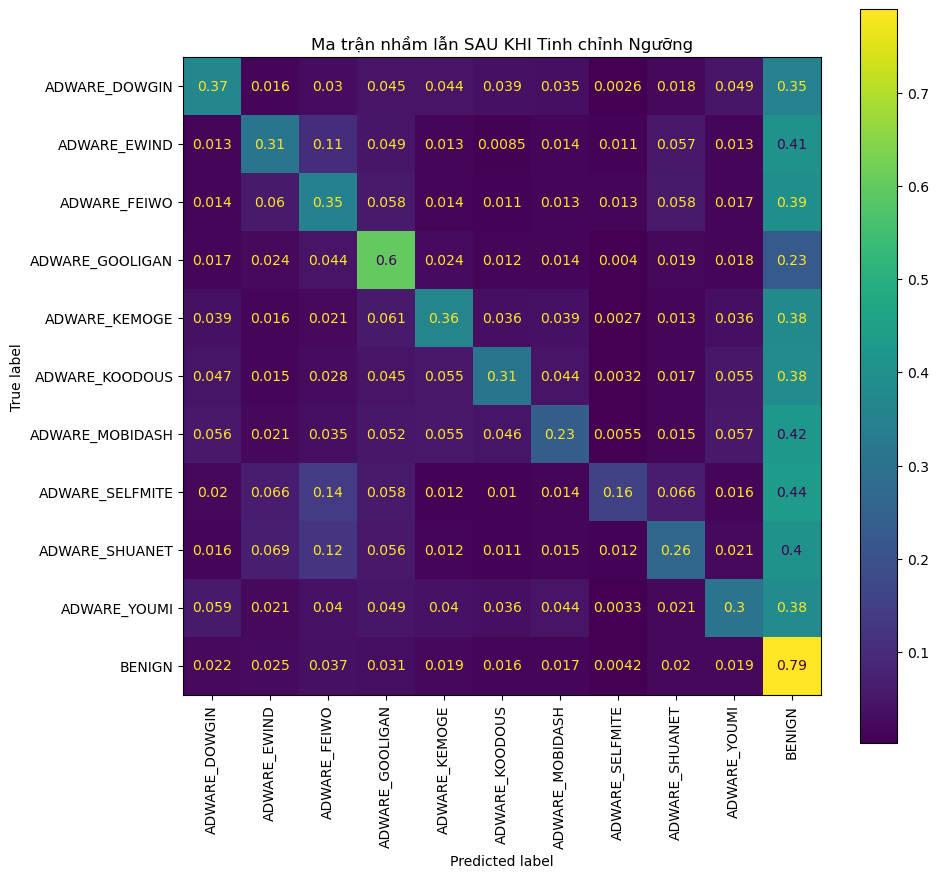

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 9))

ConfusionMatrixDisplay.from_predictions(
    y_test_enc, 
    y_pred_thr,
    display_labels=le.classes_,
    normalize="true",
    cmap="viridis",
    ax=ax
)

ax.set_title("Ma trận nhầm lẫn SAU KHI Tinh chỉnh Ngưỡng") 
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Bước 7: Lưu trữ Mô hình và các thành phần

- Lưu lại pipeline mô hình cuối cùng (`final_pipe`) để có thể tái sử dụng cho việc dự đoán trên dữ liệu mới mà không cần huấn luyện lại.

In [35]:
joblib.dump(final_pipe, "../outputs/final_model_pipeline.pkl")
print("Đã lưu mô hình cuối cùng vào file: ../outputs/final_model_pipeline.pkl")

Đã lưu mô hình cuối cùng vào file: ../outputs/final_model_pipeline.pkl


## PHẦN 2: NÂNG CAO
### 1. Ensemble Methods (Stacking)
Thay vì chỉ chọn ra một mô hình tốt nhất, ta có thể kết hợp sức mạnh của các mô hình khác nhau. Stacking hoạt động bằng cách huấn luyện một "siêu mô hình" (meta-model) để học cách kết hợp dự đoán từ các mô hình cơ sở (RandomForest và XGBoost).

In [28]:
import joblib
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# 1) Lấy XGB đã tinh chỉnh
try:
    xgb_tuned = xgb_best.named_steps['model'] 
except Exception:
    xgb_tuned = xgb_best                  

# 2) RandomForest 
try:
    rf_tuned = rf_best.named_steps['model'] 
except Exception:
    rf_tuned = rf_best                 

# 3) Base models
base_models = [
    ('rf', rf_tuned),
    ('xgb', xgb_tuned),
]

meta_model = LogisticRegression(max_iter=1000)

stacking = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=3,
    n_jobs=-1,
    verbose=2
)

# 4) Pipeline chung: preprocessor -> stacking
pipe = Pipeline([
    ('prep', preprocessor),
    ('stack', stacking)
])

# 5) Fit & đánh giá
with joblib.parallel_backend('threading'):
    pipe.fit(X_train, y_train_enc)

y_pred_stack = pipe.predict(X_test)
print("\n--- Báo cáo Phân loại của mô hình Stacking ---\n")
print(classification_report(y_test_enc, y_pred_stack, target_names=le.classes_, digits=4))


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 22.8min finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 24.1min finished



--- Báo cáo Phân loại của mô hình Stacking ---

                 precision    recall  f1-score   support

  ADWARE_DOWGIN     0.6563    0.2881    0.4004      7936
   ADWARE_EWIND     0.5555    0.2214    0.3167      8675
   ADWARE_FEIWO     0.5214    0.2577    0.3449     11327
ADWARE_GOOLIGAN     0.8417    0.5495    0.6649     18754
  ADWARE_KEMOGE     0.6590    0.3038    0.4159      7754
 ADWARE_KOODOUS     0.6801    0.2532    0.3690      6509
ADWARE_MOBIDASH     0.4920    0.1444    0.2232      6207
ADWARE_SELFMITE     0.5601    0.1002    0.1699      2606
 ADWARE_SHUANET     0.5221    0.1823    0.2703      7854
   ADWARE_YOUMI     0.5910    0.2231    0.3239      7207
         BENIGN     0.6062    0.9481    0.7396     82110

       accuracy                         0.6199    166939
      macro avg     0.6078    0.3156    0.3853    166939
   weighted avg     0.6224    0.6199    0.5687    166939

